In [1]:
import os
import json
import cv2
from tqdm import tqdm

import torch
import random
import numpy as np
from matplotlib import pyplot as plt
from pose_data import PoseGraph
from training import Trainer
from torch.utils.data import DataLoader

In [2]:
#from gpec_models.gcae import GCAE
from nf_models.model_pose import STG_NF
from nf_models.graph import Graph
#model.load_state_dict(torch.load('checkpoints/ShanghaiTech_85_9.tar')['state_dict'])
from vae import VAE, vae_loss, ae_loss

In [4]:
args = {
'no_of_files' : 10,
'channel'     : 2,
'seg_len'     : 24,
'no_of_kps'   : 18,
'seg_stride'  : 2,
'seed'        : 0,
'device'      : 'cuda:0',
'json_dir'    : {
    'train' : '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/pose/train', 
    'valid' : '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/pose/test' 
},
'gt_dir'      : {
    'valid'    :
    {
    'mask_dir'  : '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test/test_frame_mask/',
    'frame_dir' : '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test/frames/'
    },
    'train'    :
    {
    'mask_dir'  : '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/train/train_frame_mask/',
    'frame_dir' : '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/train/frames/'
    }
}
}

train_dataset = PoseGraph(args,split='train')
valid_dataset = PoseGraph(args,split='valid')
train_loader  = DataLoader(train_dataset,128)
val_loader    = DataLoader(valid_dataset,128)

#model = GCAE(in_channels=3)
model = VAE(args,2,128,hidden_dims=[2,4,8,16])#[24,48,96,192]

trainer = Trainer(model,
                  train_loader,
                  val_loader,
                  loss_func= vae_loss,#model.loss_function,
                  epochs = 5,
                  lr= 0.00001)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.81it/s]


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
#trainer.train()

In [ ]:
model.load_state_dict(torch.load('Jan28_2134__checkpoint.pth.tar')['state_dict'])

In [ ]:
#score = trainer.test()

In [ ]:
scene_ids = set(valid_dataset.meta_data[:,0])
clip_ids  = set(valid_dataset.meta_data[:,1])
scene_ids,clip_ids

In [5]:
from pose_data import Pose

In [6]:
gt,poses,frames = train_dataset.get_clip_poses(1,1)

In [7]:
vgt,vposes,vframes = valid_dataset.get_clip_poses(1,14)

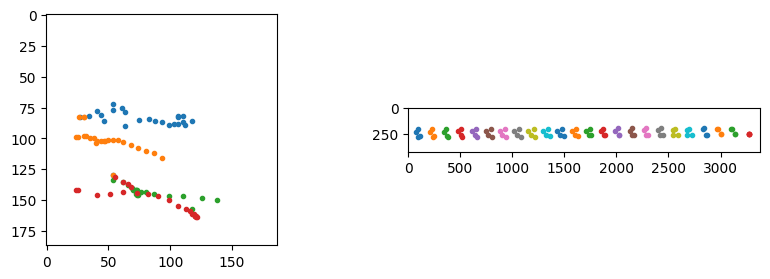

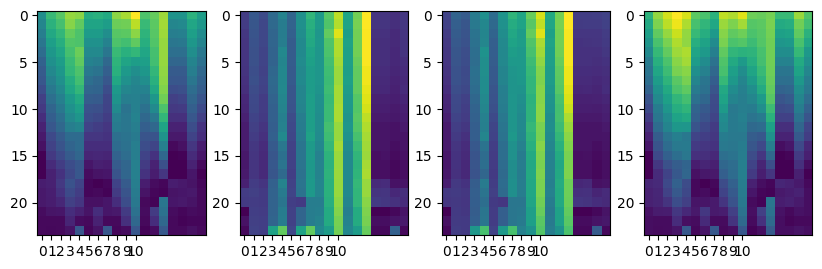

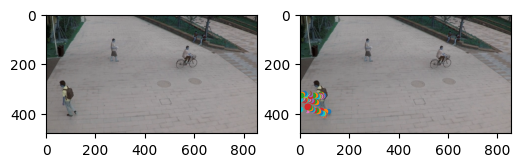

In [8]:
vposes[3][50].vis_data(_id=[4,7,10,13])
vposes[3][50].plot_hmap()
vposes[3][50].plot_pose(_id=[4,7,10,13])

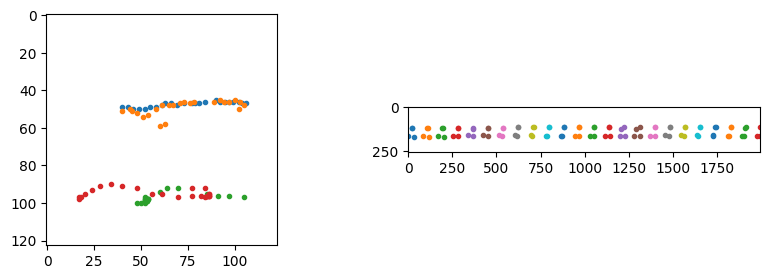

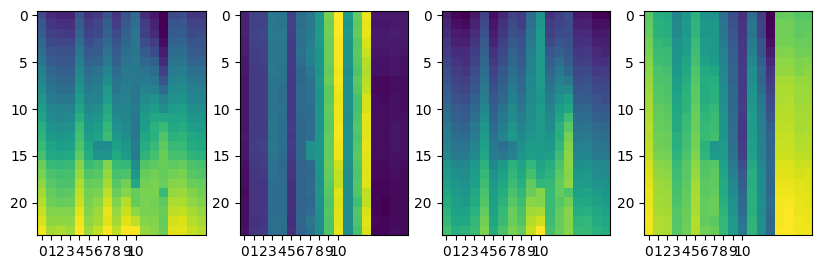

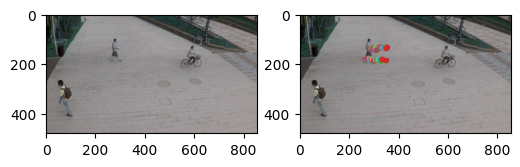

In [9]:
vposes[4][50].vis_data(_id=[4,7,10,13])
vposes[4][50].plot_hmap()
vposes[4][50].plot_pose(_id=[4,7,10,13])

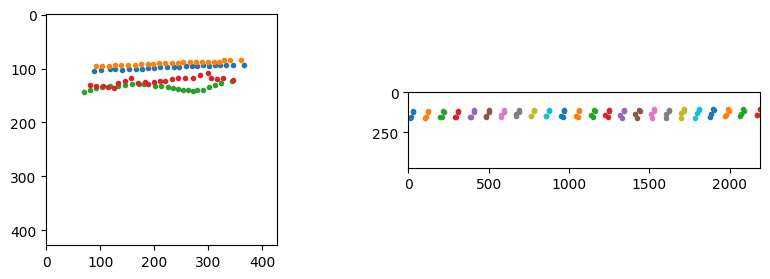

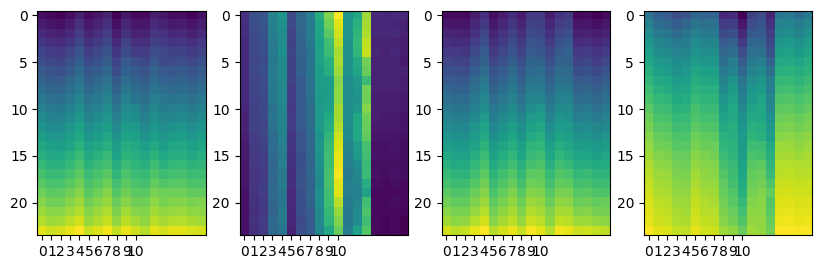

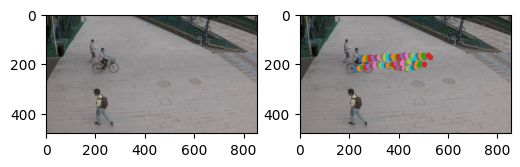

In [10]:
vposes[5][10].vis_data(_id=[4,7,10,13])
vposes[5][10].plot_hmap()
vposes[5][10].plot_pose(_id=[4,7,10,13])

In [14]:
!ls /home/irfan/Desktop/Data/Pose_JSON_Data//gt/

ls: cannot access '/home/irfan/Desktop/Data/Pose_JSON_Data//gt/': No such file or directory


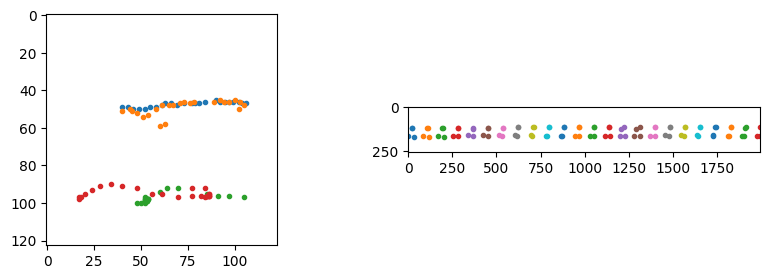

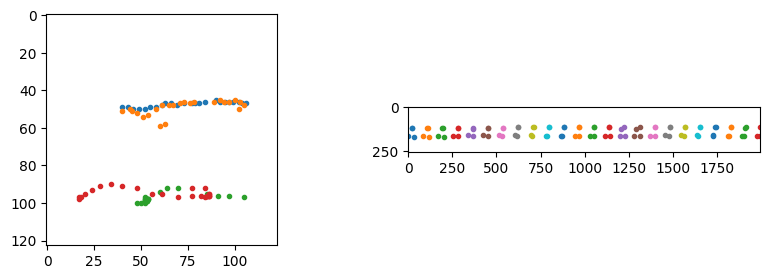

In [15]:
vposes[4][50].vis_data(_id=[4,7,10,13])
vposes[4][50].vis_data(_id=[4,7,10,13])

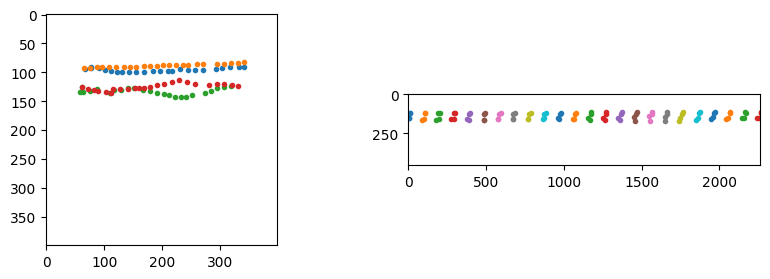

In [16]:
vposes[5][0].vis_data(_id=[4,7,10,13])

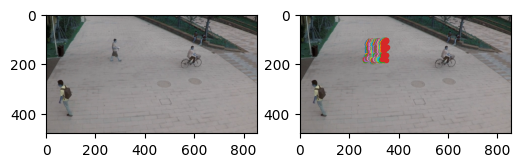

In [24]:
vposes[4][50].plot_pose()

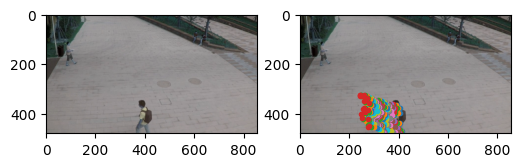

In [26]:
vposes[3][20].plot_pose()

In [ ]:
mtd = list(map(str,vposes[3][80].mtd))
fname = f"{mtd[0].zfill(2)}_{mtd[1].zfill(4)}/{mtd[3].zfill(3)}.jpg"
src = '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test/frames/'+fname
img = cv2.imread(src)

In [ ]:
mtd

In [ ]:
for frame in vframes:
    frame = cv2.imread(frame)
    plt.imshow(frame[:,:,::-1])
    plt.show()

In [ ]:
vgt,vposes,vframes = valid_dataset.get_clip_poses(1,15)

In [44]:
def test(loader):
    device='cuda:0'
    model.eval()
    model.to(device)
    pbar  = tqdm(loader)
    probs = torch.empty(0).to(device)
    mu   = torch.empty(0).to(device)
    std  = torch.empty(0).to(device)
    results = []
    print("Starting Test Eval")
    for itern, data in enumerate(pbar):
        data = data[0].to(device, non_blocking=True)
        data = data.permute(0,3,1,2)
        with torch.no_grad():
            z = model(data[:,:2,:,:])
            scores = torch.abs(z[0][:,:2] - z[1][:,:2]).mean(dim=[1,2,3])
        probs = torch.cat([probs, scores], dim=0)
        #import pdb;pdb.set_trace()
        mu  = torch.cat([mu, torch.abs(z[2])], dim=0)
        std = torch.cat([std, torch.abs(z[3])], dim=0)
        results.append(z)
        
    prob_mat_np = probs.cpu().detach().numpy().squeeze().copy(order='C')
    mu  = mu.cpu().detach().numpy()#.squeeze().copy(order='C')
    std = std.cpu().detach().numpy()#.squeeze().copy(order='C')
    
    return prob_mat_np, mu, std, results

from sklearn.metrics import roc_auc_score

def score_auc(scores_np, gt):
        scores_np[scores_np == np.inf] = scores_np[scores_np != np.inf].max()
        scores_np[scores_np == -1 * np.inf] = scores_np[scores_np != -1 * np.inf].min()
        auc = roc_auc_score(gt, scores_np)
        return auc

In [45]:
score, mu, std, res = test(train_loader)

  0%|                                                                                                                                                                               | 0/58 [00:00<?, ?it/s]


Starting Test Eval


NameError: name 'dt' is not defined

In [ ]:
tscore, tmu, tstd, tres = test(val_loader)

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=10,figsize=(20,4))
for i in range(100,110):
    axes[i%10].imshow(np.clip(mu[i:i+128].T,0,0.1))

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=10,figsize=(20,4))
for i in range(10,20):
    axes[i%10].imshow(tmu[i:i+128].T)

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(20,4))
axes.plot(np.clip(mu[0].T,  0, 0.2)) 
axes.plot(np.clip(mu[-1].T, 0, 0.2))

In [ ]:
train_dataset.plot_hmap(0)

In [ ]:
figplt.imshow(np.clip(tmu[:100].T,0,0.1))

In [ ]:
from score import Score
from scipy.ndimage import gaussian_filter1d
import os
files = os.listdir('/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test/test_frame_mask/')
res1=[]; res2=[];res3=[]
thr=0.15
for file in files[:10]:#[:25]:
    scr = Score(path='/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test/test_frame_mask/')
    #res = scr.score_dataset(np.uint8(score>thr),valid_dataset.meta_data)
    gt,pred = scr.get_clip_score(score, file, valid_dataset.meta_data)
    _pred = gaussian_filter1d(pred,sigma=7)
    res1.append(roc_auc_score(gt,np.uint8(_pred>thr)))
    
    fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(10,3))
    axes[0,0].plot(gt);axes[0,0].set_title(str(res1[-1]))
    axes[0,1].plot(np.uint8(_pred>thr));axes[0,1].set_ylim(0,0.2)
    axes[0,1].plot(_pred,alpha=0.1)
    axes[0,2].plot(pred)
    '''
    gt,pred = scr.get_clip_score(mu, file, valid_dataset.meta_data)
    _pred = gaussian_filter1d(pred,sigma=3)
    res2.append(roc_auc_score(gt,np.uint8(_pred>0.15)))
    axes[1,0].plot(gt)
    axes[1,1].plot(_pred);axes[1,1].set_ylim(0,0.8)
    axes[1,2].plot(pred)
    
    gt,pred = scr.get_clip_score(std, file, valid_dataset.meta_data)
    _pred = gaussian_filter1d(pred,sigma=3)
    res3.append(roc_auc_score(gt,np.uint8(_pred>0.15)))
    axes[2,0].plot(gt)
    axes[2,1].plot(_pred);axes[1,1].set_ylim(0,0.8)
    axes[2,2].plot(pred)
    '''
plt.close()

In [ ]:
mu.shape, score.shape

In [ ]:
np.mean(res1)
#0.65761537014756
#0.6645533892448818

#0.6480286128337436
#0.6480286128337436

In [ ]:
plt.plot(res1)
plt.plot(res2)
plt.plot(res3)

In [ ]:
gt,pred = scr.get_clip_score(score, files[0], valid_dataset.meta_data)
_pred = gaussian_filter1d(pred,sigma=3)
roc_auc_score(gt,_pred)

In [ ]:
gt.shape,pred.shape

In [ ]:
np.mean(res1),np.mean(res2),np.mean(res3)

In [ ]:
from scipy.ndimage import gaussian_gradient_magnitude1d

In [ ]:
SHANGHAITECH_HR_SKIP  = [(1, 130), (1, 135), (1, 136), (6, 144), (6, 145), (12, 152)]
def get_clip_score(scores, clip, metadata,seg_len=24,per_frame_scores_root='/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test_frame_mask/'):
        #if self.dataset == 'UBnormal':
        #    type, scene_id, clip_id = re.findall('(abnormal|normal)_scene_(\d+)_scenario(.*)_tracks.*', clip)[0]
        #    clip_id = type + "_" + clip_id
        #else:
        scene_id, clip_id = [int(i) for i in clip.replace("label", "001").split('.')[0].split('_')]
        
        if (int(scene_id), int(clip_id)) in SHANGHAITECH_HR_SKIP:
            return True
        
        clip_metadata_inds = np.where((metadata[:, 1] == clip_id) &
                                      (metadata[:, 0] == scene_id))[0]
        clip_metadata = metadata[clip_metadata_inds]
        clip_fig_idxs = set([arr[2] for arr in clip_metadata])
        clip_res_fn = os.path.join(per_frame_scores_root, clip)
        clip_gt = np.load(clip_res_fn)
        
        #if self.dataset != "UBnormal":
        #    clip_gt = np.ones(clip_gt.shape) - clip_gt  # 1 is normal, 0 is abnormal
        
        scores_zeros = np.ones(clip_gt.shape[0]) * 0
        
        if len(clip_fig_idxs) == 0:
            clip_person_scores_dict = {0: np.copy(scores_zeros)}
        else:
            clip_person_scores_dict = {i: np.copy(scores_zeros) for i in clip_fig_idxs}

        for person_id in clip_fig_idxs:
            person_metadata_inds = \
                np.where(
                    (metadata[:, 1] == clip_id) & (metadata[:, 0] == scene_id) & (metadata[:, 2] == person_id))[0]
            pid_scores = scores[person_metadata_inds]

            pid_frame_inds = np.array([metadata[i][3] for i in person_metadata_inds]).astype(int)
            clip_person_scores_dict[person_id][pid_frame_inds + int(seg_len / 2)] = pid_scores

        clip_ppl_score_arr = np.stack(list(clip_person_scores_dict.values()))
        #clip_score = np.amax(clip_ppl_score_arr, axis=0) #amin

        return clip_gt, clip_ppl_score_arr

from score import Score
from scipy.ndimage import gaussian_filter1d
import os
files = os.listdir('/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test_frame_mask/')
for file in files[:25]:
    scr = Score(path='/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test_frame_mask/')
    #res = scr.score_dataset(np.uint8(score>thr),valid_dataset.meta_data)
    gt,pred = get_clip_score(score, file, valid_dataset.meta_data)
    #mean    = pred.mean(axis=0)
    #std     = pred.std(axis=0)
    #pred   = (pred - mean)/std
    _pred   = gaussian_filter1d(pred,sigma=1)
    
    fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,3))
    axes[0].plot(gt)
    axes[1].plot(np.amax(_pred,axis=0));axes[1].set_ylim(0,0.2)
    axes[2].plot(pred.T,alpha=0.1);axes[2].set_ylim(0,0.2)
    '''
    gt,pred = scr.get_clip_score(mu, file, valid_dataset.meta_data)
    _pred = gaussian_filter1d(pred,sigma=3)
    
    axes[1,0].plot(gt)
    axes[1,1].plot(_pred);axes[1,1].set_ylim(0,0.8)
    axes[1,2].plot(pred)
    
    gt,pred = scr.get_clip_score(std, file, valid_dataset.meta_data)
    _pred = gaussian_filter1d(pred,sigma=3)
    
    axes[2,0].plot(gt)
    axes[2,1].plot(_pred);axes[1,1].set_ylim(0,0.8)
    axes[2,2].plot(pred)
    '''
plt.close()

In [ ]:
pred.shape

In [ ]:
for thr in [0.1,0.2,0.3,0.4,0.5]:
    scr = Score(path='/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test_frame_mask/')
    Eres = scr.score_dataset(np.uint8(score>thr),valid_dataset.meta_data)
    scr.get_clip_score(score, file, valid_dataset.meta_data, valid_dataset.meta_data, path)
    print(res)
    plt.plot(res[1])

In [ ]:
path= '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test_frame_mask/'
files = os.listdir(path)

In [ ]:
for file in files[:25]:
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
    a,b = scr.get_clip_score(score, file, valid_dataset.meta_data, valid_dataset.meta_data, path)
    axes[0].plot(a)
    axes[1].plot(np.uint8(b>0.2))

In [ ]:
torch.abs(elem[0]-out[0]).shape

In [ ]:
elem[0].shape,out[0].shape

In [ ]:
0.0569324716925621:

In [ ]:
for elem in train_loader:
    break
dt  = elem[0].permute(0,3,1,2)
model.to('cuda:0')
out = model(dt[:,:,:,:].float().to('cuda:0'))

In [ ]:
out[1].shape

In [ ]:
dt.shape

In [ ]:
x = elem[0].permute(0,3,1,2)

In [ ]:
y = x.unsqueeze(4)

In [ ]:
y.shape

In [ ]:
N, C, T, V, M = y.size()
y = y.permute(0, 4, 3, 1, 2).contiguous()
print(y.shape)
y = y.view(N * M, V * C, T)
print(y.shape)

In [ ]:
y = y.view(N, M, V, C, T)
print(y.shape)
y = y.permute(0, 1, 3, 4, 2).contiguous()
print(y.shape)
y = y.view(N * M, C, T, V)
print(y.shape)

In [ ]:
plt.imshow(elem[0][0,:,:,0].detach().cpu())

In [ ]:
plt.imshow(out[0][0,0,:,:].detach().cpu())

In [ ]:
import torchvision
oo = out[0][:,:,:,:].detach().cpu()
ot = torchvision.transforms.Resize((32,32))(oo)

In [ ]:
ot.shape

In [ ]:
from gpec_models.gcae.gcae import Encoder
from gpec_models.fe.fe_model import init_fenet
model = init_fenet(None)

In [ ]:
model

In [ ]:
import torch
torch.resize()

In [ ]:
import torch
_dt   = torch.tensor(dt.transpose(2,0,1)[None],dtype=torch.float32).to('cuda:0')
model.train()
model = model.to('cuda:0')
out   = model(_dt)

In [ ]:
out[0][0].shape

In [ ]:
_t = dt
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,3))
axes[0].imshow(_t[:,:,0])
axes[1].imshow(_t[:,:,1])
axes[2].imshow(_t[:,:,2])

In [ ]:
_t = out[0][0].detach().cpu().numpy().transpose(1,2,0)
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,3))
axes[0].imshow(_t[:,:,0])
axes[1].imshow(_t[:,:,1])
axes[2].imshow(_t[:,:,2])

In [ ]:
dt,mtd = pg.__getitem__(786)
#_dt    = dt.transpose(1,2,0)
dt[:,:,0]-=dt[:,:,0].min()
dt[:,:,1]-=dt[:,:,1].min()
dt[:,:,0]/=dt[:,:,0].max()
dt[:,:,1]/=dt[:,:,1].max()
dt[:,:,2]/=dt[:,:,2].max()
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,4))
axes[0].imshow(dt[:,:,0])
axes[1].imshow(dt[:,:,1])
axes[2].imshow(dt[:,:,2])

In [ ]:
dt,mtd = pg.__getitem__(400)
#_dt    = dt.transpose(1,2,0)
dt[:,:,0]-=dt[:,:,0].min()
dt[:,:,1]-=dt[:,:,1].min()
dt[:,:,0]/=dt[:,:,0].max()
dt[:,:,1]/=dt[:,:,1].max()
dt[:,:,2]=0
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
axes[0].imshow(dt[:,:,0])
axes[1].imshow(dt[:,:,2])

In [ ]:
dt[:,:,2].max()

In [ ]:
dt.min()

In [ ]:
plot_pose(dt,mtd)

In [ ]:
size  = dt.max().astype('int32')
frame = np.zeros((size,size,3),dtype=np.uint8)

In [ ]:
vis_data(_dt)

In [ ]:
__dt[:,:,1].max()

In [ ]:
import argparse
import os.path as osp
import time
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GAE, VGAE, GCNConv

parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument('--variational', action='store_true')
parser.add_argument('--linear', action='store_true')
parser.add_argument('--dataset', type=str, default='Cora',
                    choices=['Cora', 'CiteSeer', 'PubMed'])
parser.add_argument('--epochs', type=int, default=400)
args = parser.parse_args()

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False),
])
path = osp.join(osp.dirname(osp.realpath('.')), '..', 'data', 'Planetoid')
dataset = Planetoid(path, args.dataset, transform=transform)
train_data, val_data, test_data = dataset[0]


class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)


class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


class LinearEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.conv(x, edge_index)


class VariationalLinearEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_mu = GCNConv(in_channels, out_channels)
        self.conv_logstd = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


in_channels, out_channels = dataset.num_features, 16

if not args.variational and not args.linear:
    model = GAE(GCNEncoder(in_channels, out_channels))
elif not args.variational and args.linear:
    model = GAE(LinearEncoder(in_channels, out_channels))
elif args.variational and not args.linear:
    model = VGAE(VariationalGCNEncoder(in_channels, out_channels))
elif args.variational and args.linear:
    model = VGAE(VariationalLinearEncoder(in_channels, out_channels))

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index)
    if args.variational:
        loss = loss + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)


times = []
for epoch in range(1, args.epochs + 1):
    start = time.time()
    loss = train()
    auc, ap = test(test_data)
    print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")